### Remember, Discriminator doesnt have to be opposite of Generator, they are 2 different CNN networks.

In [54]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import os

In [55]:
def gradient_penalty(critic, real, fake, device='cpu'):
    BATCH_SIZE, C, H, W = real.shape
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolation_images = real * epsilon + fake * (1 - epsilon)

    # calculate critic scores
    mixed_scores = critic(interpolation_images) # scores of the different interpolated images

    gradient = torch.autograd.grad(
        inputs=interpolation_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [56]:


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [57]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [58]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W)).to(device)
    disc = Discriminator(in_channels, 8).to(device)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)

    z = torch.randn((N, z_dim, 1, 1)).to(device)
    gen = Generator(z_dim, in_channels, 8).to(device)
    initialize_weights(gen)
    assert gen(z).shape == (N, in_channels, H, W)

    print("Success")


test()

Success


In [60]:
disriminator = Discriminator(3, 8).to(device)
summary(disriminator, (3,64,64))
# summary(generator, (1,1, 1))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             392
         LeakyReLU-2            [-1, 8, 32, 32]               0
            Conv2d-3           [-1, 16, 16, 16]           2,048
    InstanceNorm2d-4           [-1, 16, 16, 16]              32
         LeakyReLU-5           [-1, 16, 16, 16]               0
            Conv2d-6             [-1, 32, 8, 8]           8,192
    InstanceNorm2d-7             [-1, 32, 8, 8]              64
         LeakyReLU-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 4, 4]          32,768
   InstanceNorm2d-10             [-1, 64, 4, 4]             128
        LeakyReLU-11             [-1, 64, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           1,025
Total params: 44,649
Trainable params: 44,649
Non-trainable params: 0
---------------------------------

In [61]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [62]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [63]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms, download=True)

In [64]:
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
# initialize_weights(gen)
# initialize_weights(disc)

In [65]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
# criterion = nn.BCELoss()

In [66]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f'logs/real')
writer_fake = SummaryWriter(f'logs/fake')
step = 0

In [67]:

# Define directories to save the weights
SAVE_MODEL_DIR = "checkpoints_torch_wganGP"
GEN_WEIGHTS_DIR = os.path.join(SAVE_MODEL_DIR, "generator")
DISC_WEIGHTS_DIR = os.path.join(SAVE_MODEL_DIR, "discriminator")


# Create directories if they don't exist
os.makedirs(GEN_WEIGHTS_DIR, exist_ok=True)
os.makedirs(DISC_WEIGHTS_DIR, exist_ok=True)


In [68]:

# # Load Generator weights
# gen.load_state_dict(torch.load(os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_100.pth")))
# gen.to(device)  # Move Generator to the device

# # Load Discriminator weights
# disc.load_state_dict(torch.load(os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_100.pth")))
# disc.to(device)  # Move Discriminator to the device

# print(f"Loaded Generator and Discriminator weights for epoch {100}")


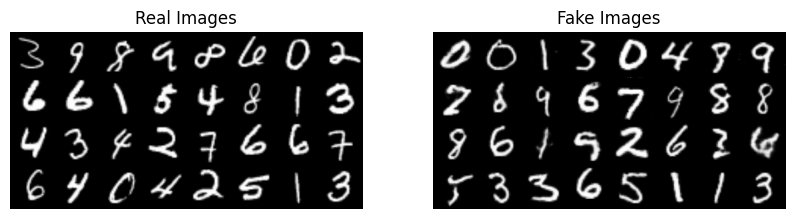

Saved Generator and Discriminator weights for epoch 31


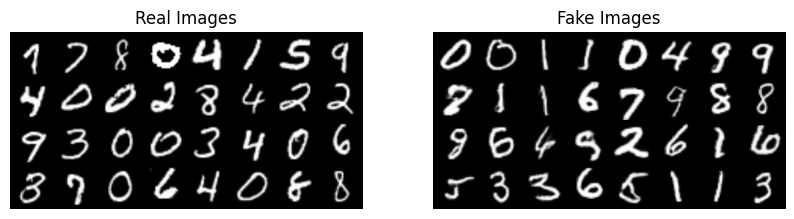

Saved Generator and Discriminator weights for epoch 36


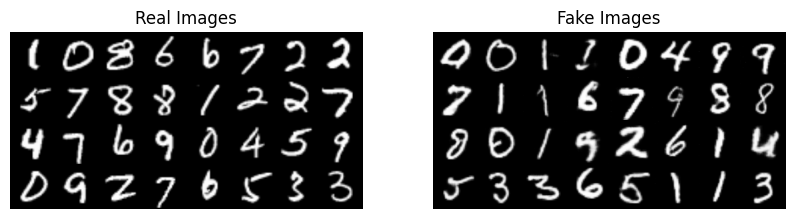

Saved Generator and Discriminator weights for epoch 41


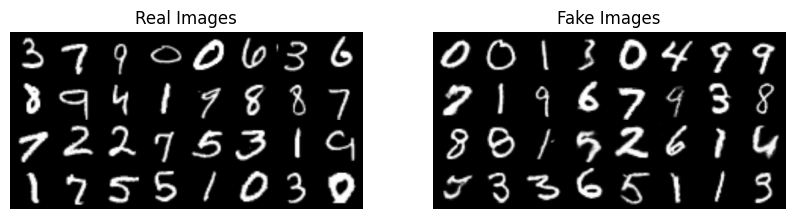

Saved Generator and Discriminator weights for epoch 46


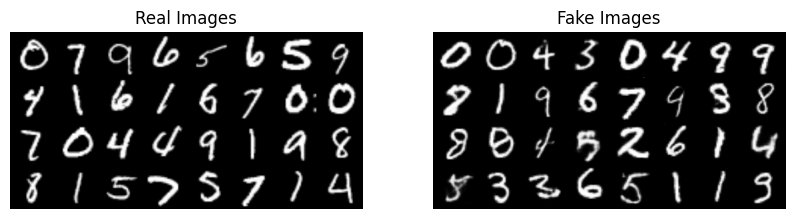

Saved Generator and Discriminator weights for epoch 51


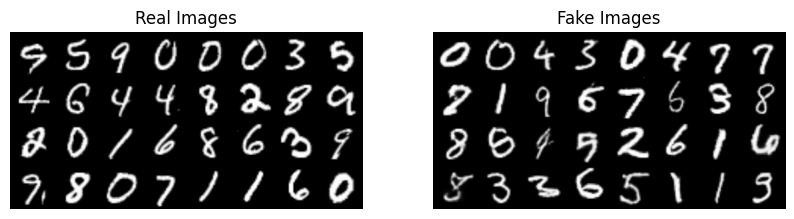

Saved Generator and Discriminator weights for epoch 56


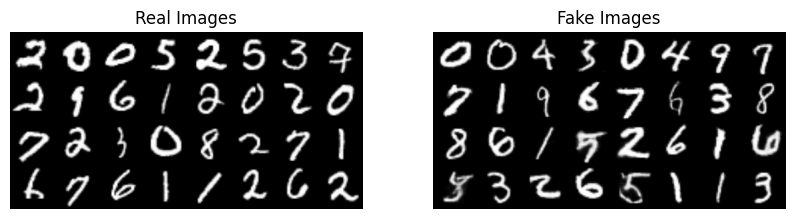

Saved Generator and Discriminator weights for epoch 61


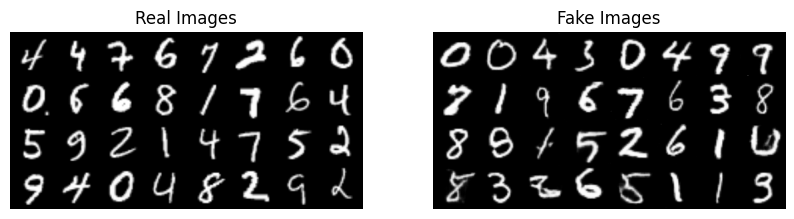

Saved Generator and Discriminator weights for epoch 66


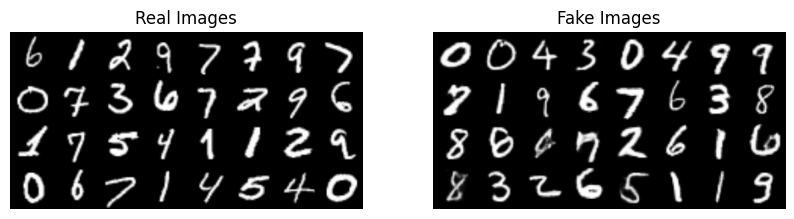

Saved Generator and Discriminator weights for epoch 71


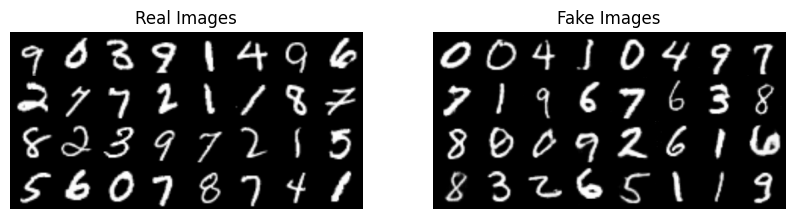

Saved Generator and Discriminator weights for epoch 76


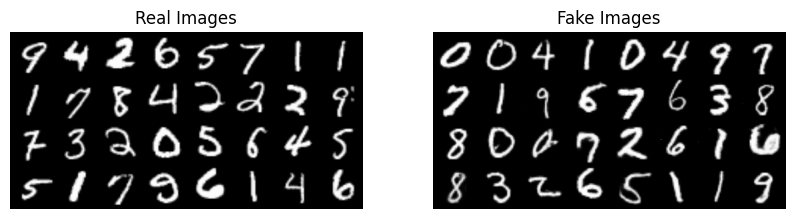

Saved Generator and Discriminator weights for epoch 81


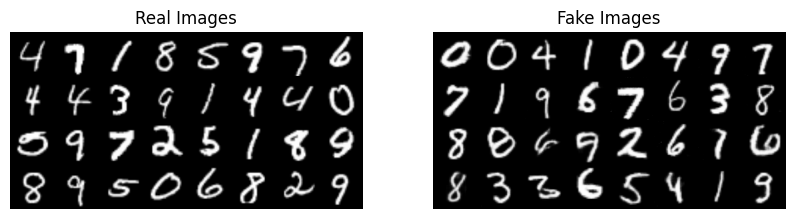

Saved Generator and Discriminator weights for epoch 86


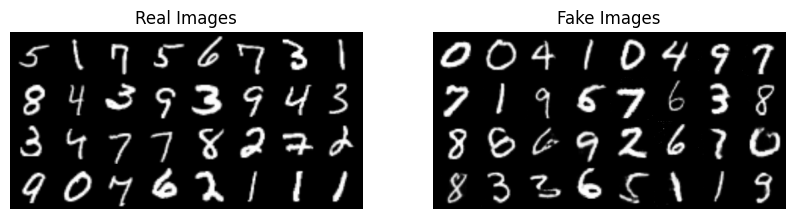

Saved Generator and Discriminator weights for epoch 91


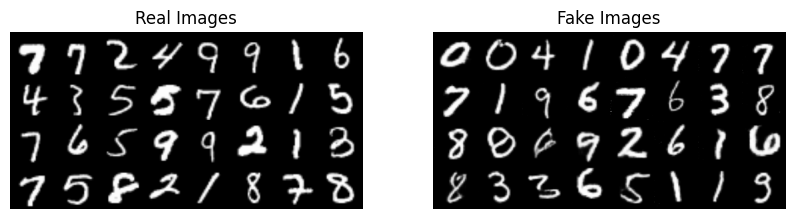

Saved Generator and Discriminator weights for epoch 96


In [72]:
gen.train()
disc.train()

for epoch in range(27, NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[disc(real)] - E[disc(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            gp = gradient_penalty(disc, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_disc.step()

        # Train Generator: max E[disc(gen_fake)] <-> min -E[disc(gen_fake)]
        gen_fake = disc(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            # print(
            #     f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
            #       Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            # )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            
    if epoch % 5 == 0:
        # Convert images from torch.Tensor to numpy array for plotting
        img_real = img_grid_real.permute(1, 2, 0).cpu().numpy()
        img_fake = img_grid_fake.permute(1, 2, 0).cpu().numpy()

        # Plot the real and fake images side by side
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Real Images")
        plt.imshow(img_real)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Fake Images")
        plt.imshow(img_fake)
        plt.axis("off")

        plt.show()

        # Save model weights after each epoch
        gen_path = os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_{epoch+1}.pth")
        disc_path = os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_{epoch+1}.pth")
        
        torch.save(gen.state_dict(), gen_path)
        torch.save(disc.state_dict(), disc_path)
        print(f"Saved Generator and Discriminator weights for epoch {epoch+1}")
        

In [73]:
# Save model weights after each epoch
gen_path = os.path.join(GEN_WEIGHTS_DIR, f"gen_epoch_{epoch+1}.pth")
disc_path = os.path.join(DISC_WEIGHTS_DIR, f"disc_epoch_{epoch+1}.pth")

torch.save(gen.state_dict(), gen_path)
torch.save(disc.state_dict(), disc_path)
print(f"Saved Generator and Discriminator weights for epoch {epoch+1}")

Saved Generator and Discriminator weights for epoch 100
